In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
import os
import sys

In [ ]:
# package_path = '/content/drive/MyDrive/'
# sys.path.insert(0, package_path)
# sys.path

In [4]:
! mkdir /content/data
! cp /content/drive/MyDrive/train_data/positive_binary.zip /content/data

In [ ]:
!mkdir /content/data/positive
!unzip -j /content/data/positive_binary.zip -d /content/data/positive

In [6]:
len(os.listdir('/content/data/positive'))

49436

In [7]:
from fastai.vision.all import *
from fastai.vision.data import *
from pathlib import Path
from os.path import join
import pandas as pd

In [8]:
class CustomSegmentationDataLoaders(DataLoaders):
    "Basic wrapper around several `DataLoader`s with factory methods for segmentation problems"

    @classmethod
    @delegates(DataLoaders.from_dblock)
    def from_label_func(cls, path, fnames, label_func, valid_idx, codes=None, item_tfms=None,
                        batch_tfms=None,
                        img_cls=PILImage, **kwargs):
        "Create from list of `fnames` in `path`s with `label_func`."
        dblock = DataBlock(blocks=(ImageBlock(img_cls), MaskBlock(codes=codes)),
                           splitter=IndexSplitter(valid_idx),
                           get_y=label_func,
                           item_tfms=item_tfms,
                           batch_tfms=batch_tfms)
        res = cls.from_dblock(dblock, fnames, path=path, **kwargs)
        return res

In [9]:
path = Path('/content/data')

In [10]:
df_file_name_split = pd.read_csv('/content/drive/MyDrive/train_data/file_name_split.csv')
df_file_name_split.head()

,file_path,dataset
0,positive/5e4389b28_640_128_768_256.jpg,train
1,positive/47d99bdca_384_512_512_640.jpg,train
2,positive/47d99bdca_512_512_640_640.jpg,train
3,positive/47d99bdca_384_384_512_512.jpg,train
4,positive/47d99bdca_512_384_640_512.jpg,train


In [11]:
image_path_list_train = df_file_name_split[df_file_name_split['dataset'] == 'train']['file_path']
image_path_list_val = df_file_name_split[df_file_name_split['dataset'] == 'val']['file_path'].sample(n=150, random_state=42)
len(image_path_list_train), len(image_path_list_val)

(20369, 150)

In [12]:
image_path_list = image_path_list_val.tolist() + image_path_list_train.tolist()
image_full_path_list = [Path(join('/content/data/', p)) for p in image_path_list]
val_index_list = list(range(len(image_path_list_val)))

In [13]:
def img_path_to_label_path(image_path):
    return image_path.parent / f'{image_path.stem}.png'


dls = CustomSegmentationDataLoaders.from_label_func(
    path,
    bs=2,
    n=50,
    fnames=image_full_path_list,
    label_func=img_path_to_label_path,
    valid_idx=val_index_list,
    item_tfms=Resize(size=(1024, 1024), method=ResizeMethod.Squish),
    codes=[
        'sea',
        'ship'
    ]
)

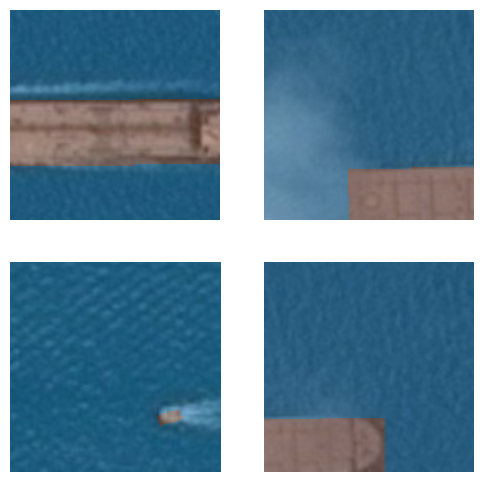

In [ ]:
dls.show_batch(max_n=6)

In [14]:
Config.DEFAULT_CONFIG = {
        'data_path': '/content/drive/MyDrive/train_data/fastai_models',
        'model_path': '/content/drive/MyDrive/train_data/fastai_models',
}

os.environ['TORCH_HOME'] = '/content/drive/MyDrive/train_data/fastai_models'

In [15]:
@patch
@delegates(subplots)
def plot_metrics(self: Recorder, nrows=None, ncols=None, figsize=None, **kwargs):
    metrics = np.stack(self.values)
    names = self.metric_names[1:-1]
    n = len(names) - 1
    if nrows is None and ncols is None:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None: nrows = int(np.ceil(n / ncols))
    elif ncols is None: ncols = int(np.ceil(n / nrows))
    figsize = figsize or (ncols * 6, nrows * 4)
    fig, axs = subplots(nrows, ncols, figsize=figsize, **kwargs)
    axs = [ax if i < n else ax.set_axis_off() for i, ax in enumerate(axs.flatten())][:n]
    for i, (name, ax) in enumerate(zip(names, [axs[0]] + axs)):
        ax.plot(metrics[:, i], color='#1f77b4' if i == 0 else '#ff7f0e', label='valid' if i > 0 else 'train')
        ax.set_title(name if i > 1 else 'losses')
        ax.legend(loc='best')
    plt.show()

In [37]:
learn = unet_learner(dls, resnet34, n_out=2, metrics=[Dice(), foreground_acc],
                     #  self_attention=True  # experement with this param
)

In [38]:
learn.path = Path('/content/drive/MyDrive/train_data/models')
learn.model_dir = 'unet'

SuggestedLRs(valley=0.00010964782268274575)

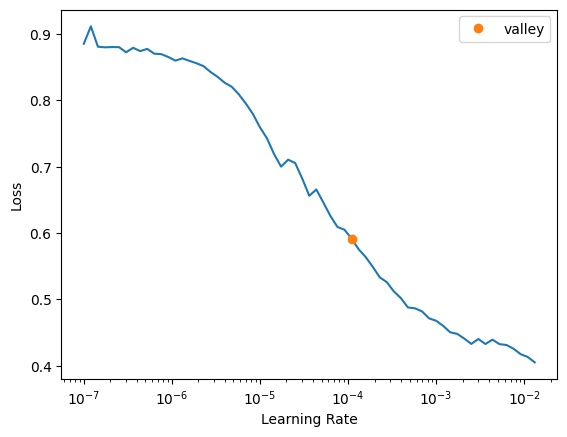

In [ ]:
learn.lr_find()

In [34]:
learn.load("/content/drive/MyDrive/train_data/models/unet/model")  # resume from checkpoint

In [36]:
# docs found at:
# https://github.com/fastai/fastai/blob/f2ab8ba78b63b2f4ebd64ea440b9886a2b9e7b6f/fastai/callback/schedule.py#L153
# https://docs.fast.ai/callback.schedule.html
# learn.fine_tune(
#     epochs=2,  # epoches to train full net
#     # base_lr=0.0001,  # max learning rate of the stage of last layer train
#     freeze_epochs=4,  # epoches to train last layer
#     cbs=[ShowGraphCallback(), SaveModelCallback(with_opt=True, fname="model")],
#     # lr_mult=100,  # base_lr / (2*lr_mult) is a max learning rate for last layer while training full net
#     # pct_start=0.3,  # part of full net training with learning rate growth. For last layer train this param is 0.99
#     # div=5.0,  # lr_max/div is a start lr for full net train (actually base_lr / (2*lr_mult*div))
#     # div_final=100000.0,  # lr_max/div_final is a final learning rate for last layer and full net train
#     start_epoch=3
# )

IndexError: ignored

In [51]:
device = torch.device('cuda')

In [52]:
learn.load('custom_model', device=device, with_opt=True, strict=True)

In [44]:
learn.freeze()

In [54]:
learn.fit(
    n_epoch=10,
    lr=0.0001,
    cbs=[ShowGraphCallback()],
    start_epoch=5,
    reset_opt=False,
)

IndexError: ignored

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit(
    n_epoch=5,
    lr=0.001,
    cbs=[ShowGraphCallback()],
    start_epoch=0,
    reset_opt=False,
)

In [47]:
learn.save('custom_model', with_opt=True, pickle_protocol=2)

Path('/content/drive/MyDrive/train_data/models/unet/custom_model.pth')

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
interp = SegmentationInterpretation.from_learner(learn)
interp.plot_top_losses(k=3)

# Classic example

In [ ]:
path = untar_data(URLs.CAMVID_TINY)
path.ls()

(#3) [Path('/root/.fastai/data/camvid_tiny/images'),Path('/root/.fastai/data/camvid_tiny/codes.txt'),Path('/root/.fastai/data/camvid_tiny/labels')]

In [ ]:
codes = np.loadtxt(path/'codes.txt', dtype=str)
codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car',
       'CartLuggagePram', 'Child', 'Column_Pole', 'Fence', 'LaneMkgsDriv',
       'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving',
       'ParkingBlock', 'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk',
       'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel',
       'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [ ]:
fnames = get_image_files(path/"images")[:10]
fnames[0]

Path('/root/.fastai/data/camvid_tiny/images/0016E5_08400.png')

In [ ]:
(path/"labels").ls()[0]

Path('/root/.fastai/data/camvid_tiny/labels/Seq05VD_f03660_P.png')

In [ ]:
def label_func(fn): return path/"labels"/f"{fn.stem}_P{fn.suffix}"

In [ ]:
dls = SegmentationDataLoaders.from_label_func(
    path, bs=8, fnames = fnames, label_func = label_func, codes = codes
)

/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)


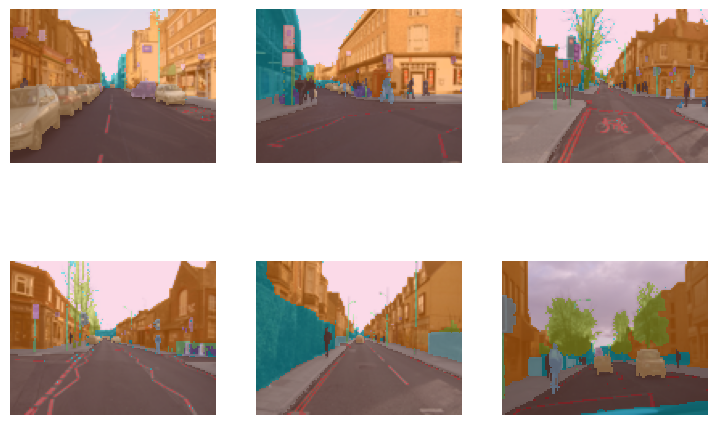

In [ ]:
dls.show_batch(max_n=6)

In [ ]:
learn = unet_learner(dls, resnet34, metrics=[Dice(), foreground_acc])
learn.fine_tune(1)

epoch,train_loss,valid_loss,dice,foreground_acc,time
0,3.790559,3.390733,14.457929,0.033203,00:10


epoch,train_loss,valid_loss,dice,foreground_acc,time
0,3.439808,3.149598,14.683904,0.273478,00:09


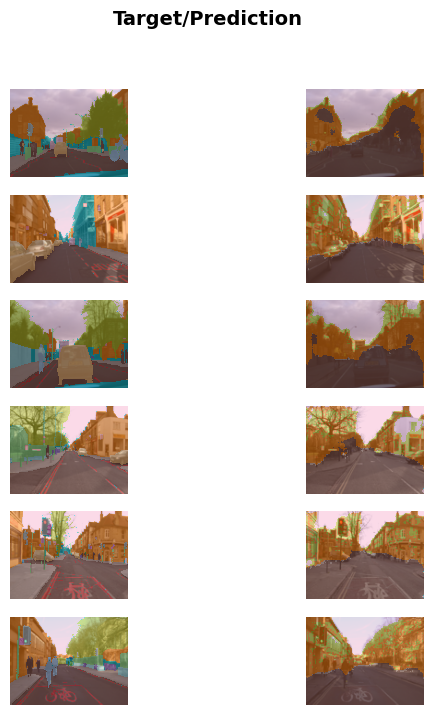

In [ ]:
learn.show_results(max_n=6, figsize=(7,8))

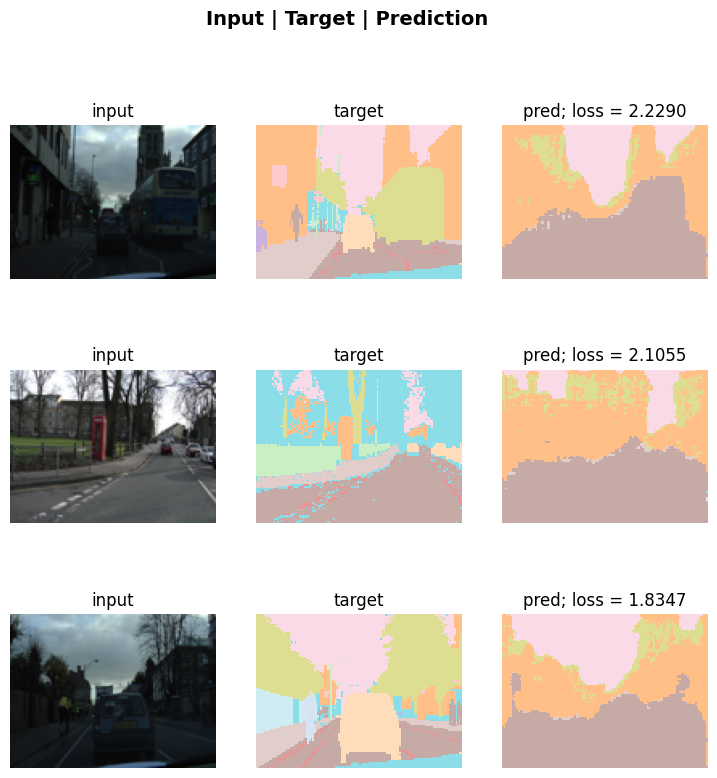

In [ ]:
interp = SegmentationInterpretation.from_learner(learn)
interp.plot_top_losses(k=3)

In [ ]:
!nvidia-smi

Mon Dec 11 19:30:44 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P0    30W /  70W |    699MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
torch.cuda.empty_cache()